In [121]:
%load_ext autoreload
%autoreload 2

In [415]:
import torch
import torch.nn as nn
import torchvision.models as models
from utils import Dataset
import torch.nn.functional as F
from torch import optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['figure.figsize'] = (12,6)


Setup a baseline to compare k-winners, which is fast to train and evaluate

In [103]:
dataset = Dataset(config=dict(dataset_name='MNIST', data_dir='~/nta/datasets',
                             batch_size_train=256, batch_size_test=1024))

In [107]:
# torch cross_entropy is log softmax activation + negative log likelihood
loss_func = F.cross_entropy

# a custom Lambda module
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

# simple feedforward model
# use a lambda layer to resize 
model = nn.Sequential(
    Lambda(lambda x: x.view(-1,28*28)),
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Linear(100,10),
)
  
# calculate accuracy
def accuracy(loader, num_batches=3):
    len_dataset = loader.dataset.data.size()[0]
    running_acc = 0
    running_count = 0
    # do no cover entire dataset. training is shuffled, testing is not
    iter_loader = iter(loader)
    for _ in range(num_batches):
        x,y = next(iter_loader)
        out = model(x)
        preds = torch.argmax(out, dim=1)
        running_acc += (preds == y).float().sum()
        running_count += x.size()[0]
        
    return running_acc.item() / running_count  


In [497]:
# baseline
def fit(model, dataset, verbose=True, epochs=1, epoch_eval=True):
    test_accuracies = []
    losses = []
    # dataset
    train_loader = dataset.train_loader
    test_loader = dataset.test_loader
    # hyperparams
    opt = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
    num_batches = 60
    # training loop
    print("Training Accuracy before training: {:.4f}".format(accuracy(train_loader)))
    for epoch in range(epochs):
        model.train()
        iter_loader = iter(train_loader)    
        for i in range(num_batches):
            x,y = next(iter_loader)
            # calculate loss
            loss = loss_func(model(x), y)
            losses.append(loss.item())
            # backpropagate
            loss.backward()
            # learn
            opt.step()
            opt.zero_grad()
            if verbose:
                if i % 20 == 0:
                    print("Loss: {:.8f}".format(loss.item()*1000/len(x)))
        
        if epoch_eval:
            model.eval()
            test_acc = accuracy(test_loader)
            test_accuracies.append(test_acc)
        
    model.eval()
    print("Training Accuracy after training: {:.4f}".format(accuracy(train_loader)))
    print("Test Accuracy after training: {:.4f}".format(accuracy(test_loader)))
    print("---------------------------")
    
    return losses, test_accuracies

In [109]:
fit(model, dataset)

Training Accuracy before training: 0.1680
Loss: 8.86095315
Loss: 3.45818489
Loss: 1.58749637
Training Accuracy after training: 0.8906
Test Accuracy after training: 0.8617
---------------------------


#### Extend for the k-Winners simulation:

In [408]:
# from functions import KWinnersBatch as KWinners
from functions import KWinners
model_gen = lambda k: nn.Sequential(
    Lambda(lambda x: x.view(-1,28*28)),
    nn.Linear(784,100),
    KWinners(k_perc=k),
    nn.Linear(100,10),
)

model = model_gen(.1)
fit(model, dataset, epochs=1)

Training Accuracy before training: 0.0964
Loss: 9.14294273
Loss: 4.20531072
Loss: 1.95618416
Training Accuracy after training: 0.8529
Test Accuracy after training: 0.8109
---------------------------


In [356]:
for k in np.arange(0.01,1,0.1):
    print("K: %f" % k)
    model = model_gen(k) 
    fit(model, dataset, verbose=False)

K: 0.010000
Training Accuracy before training: 0.0977
Training Accuracy after training: 0.1823
Test Accuracy after training: 0.2087
---------------------------
K: 0.110000
Training Accuracy before training: 0.1133
Training Accuracy after training: 0.7305
Test Accuracy after training: 0.7109
---------------------------
K: 0.210000
Training Accuracy before training: 0.0898
Training Accuracy after training: 0.8203
Test Accuracy after training: 0.8037
---------------------------
K: 0.310000
Training Accuracy before training: 0.0911
Training Accuracy after training: 0.8529
Test Accuracy after training: 0.8411
---------------------------
K: 0.410000
Training Accuracy before training: 0.1068
Training Accuracy after training: 0.8477
Test Accuracy after training: 0.8245
---------------------------
K: 0.510000
Training Accuracy before training: 0.0755
Training Accuracy after training: 0.8815
Test Accuracy after training: 0.8486
---------------------------
K: 0.610000
Training Accuracy before tra

Model accuracy with 1% of active neurons, with and without boosting:

In [249]:
# no non-linearity required to get a low accuracy
model = nn.Sequential(
    Lambda(lambda x: x.view(-1,28*28)),
    nn.Linear(784,100),
    nn.Linear(100,10),
)
fit(model, dataset)

Training Accuracy before training: 0.0768
Loss: 9.16984864
Loss: 2.52443319
Loss: 1.56559551
Training Accuracy after training: 0.8919
Test Accuracy after training: 0.8630
---------------------------


#### Extend to CNNs

Further tests and comparison

In [416]:
# simple CNN Model
non_linearity = nn.ReLU
model = nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    non_linearity(),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    non_linearity(),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    non_linearity(),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)
losses, accs = fit(model, dataset, epochs=20)

Training Accuracy before training: 0.0977
Loss: 9.01591964
Loss: 8.31630360
Loss: 2.41597765
Loss: 1.87853654
Loss: 2.01450428
Loss: 1.43476040
Loss: 1.32107059
Loss: 1.22576545
Loss: 0.77787635
Loss: 0.91777480
Loss: 0.80468395
Loss: 0.97725971
Loss: 0.91118726
Loss: 0.53855963
Loss: 0.57668181
Loss: 0.66801795
Loss: 0.61882939
Loss: 0.38357661
Loss: 0.64914837
Loss: 0.52336586
Loss: 0.62132406
Loss: 0.46719360
Loss: 0.47875027
Loss: 0.46436820
Loss: 0.64608682
Loss: 0.40764842
Loss: 0.27636855
Loss: 0.37904861
Loss: 0.28149094
Loss: 0.42086712
Loss: 0.32278395
Loss: 0.28765490
Loss: 0.59745915
Loss: 0.46983990
Loss: 0.62205613
Loss: 0.29754065
Loss: 0.22269128
Loss: 0.43646299
Loss: 0.23136851
Loss: 0.18707171
Loss: 0.21003128
Loss: 0.39961765
Loss: 0.18117669
Loss: 0.16319507
Loss: 0.32178446
Loss: 0.15433319
Loss: 0.24375597
Loss: 0.22575687
Loss: 0.14690486
Loss: 0.30929525
Loss: 0.09941603
Loss: 0.30509694
Loss: 0.13194060
Loss: 0.24089994
Loss: 0.25497915
Loss: 0.23787981
Loss: 

In [418]:
# kWinners
from functions import KWinners
model_gen = lambda k: nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    KWinners(k_perc=k),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    KWinners(k_perc=k),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    KWinners(k_perc=k),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)

model = model_gen(k=0.25)
kw_losses, kw_accs = fit(model, dataset, epochs=20)

Training Accuracy before training: 0.1029
Loss: 8.96801241
Loss: 3.06582148
Loss: 1.94012583
Loss: 2.02102750
Loss: 1.34406553
Loss: 1.87980209
Loss: 1.13920833
Loss: 1.22467999
Loss: 1.49299891
Loss: 1.22825115
Loss: 1.60129461
Loss: 1.23011169
Loss: 1.36455195
Loss: 1.39456335
Loss: 1.48341618
Loss: 1.41690241
Loss: 1.20578543
Loss: 1.52827904
Loss: 1.05158892
Loss: 1.27736642
Loss: 1.81873434
Loss: 1.23656099
Loss: 1.15134846
Loss: 1.55259133
Loss: 1.21808599
Loss: 1.27092609
Loss: 1.08659372
Loss: 1.27634523
Loss: 1.21774606
Loss: 1.42457709
Loss: 1.00178621
Loss: 1.31482806
Loss: 1.15789764
Loss: 1.32989080
Loss: 1.24805828
Loss: 1.18830928
Loss: 0.91247406
Loss: 1.32787740
Loss: 1.55617401
Loss: 1.15874608
Loss: 0.96375117
Loss: 1.62406103
Loss: 1.44307211
Loss: 1.08400709
Loss: 0.92198735
Loss: 1.26788346
Loss: 1.42064027
Loss: 1.18913536
Loss: 1.29507936
Loss: 1.01640844
Loss: 1.65735430
Loss: 1.28937559
Loss: 1.04315509
Loss: 0.90763328
Loss: 0.94556110
Loss: 0.92524861
Loss: 

In [437]:
# kWinners
from functions import KWinners
model_gen = lambda k: nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    KWinners(k_perc=k, use_absolute=False),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    KWinners(k_perc=k, use_absolute=False),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    KWinners(k_perc=k, use_absolute=False),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)

model = model_gen(k=0.25)
kwp_losses, kwp_accs = fit(model, dataset, epochs=20)

Training Accuracy before training: 0.0781
Loss: 8.98863841
Loss: 8.51961784
Loss: 3.89555935
Loss: 2.16993084
Loss: 1.74177578
Loss: 1.29505887
Loss: 1.54911226
Loss: 1.37490628
Loss: 1.58173812
Loss: 0.89562114
Loss: 1.21299771
Loss: 1.08736753
Loss: 1.01180549
Loss: 0.94258174
Loss: 0.67333027
Loss: 1.15846109
Loss: 0.58816507
Loss: 0.48005674
Loss: 0.37854345
Loss: 0.56073791
Loss: 0.62870054
Loss: 0.66439097
Loss: 0.42711181
Loss: 0.60873589
Loss: 0.36493287
Loss: 0.44638448
Loss: 0.28564816
Loss: 0.40550501
Loss: 0.46862161
Loss: 0.54111570
Loss: 0.39297619
Loss: 0.66374434
Loss: 0.40825043
Loss: 0.35721733
Loss: 0.25609633
Loss: 0.27336623
Loss: 0.43698720
Loss: 0.45553839
Loss: 0.30519644
Loss: 0.36657095
Loss: 0.43717056
Loss: 0.27034053
Loss: 0.30268749
Loss: 0.25070496
Loss: 0.22197841
Loss: 0.43891702
Loss: 0.38769090
Loss: 0.39445105
Loss: 0.20566507
Loss: 0.50744601
Loss: 0.32244410
Loss: 0.38550625
Loss: 0.37734438
Loss: 0.74301276
Loss: 0.37948275
Loss: 0.28699744
Loss: 

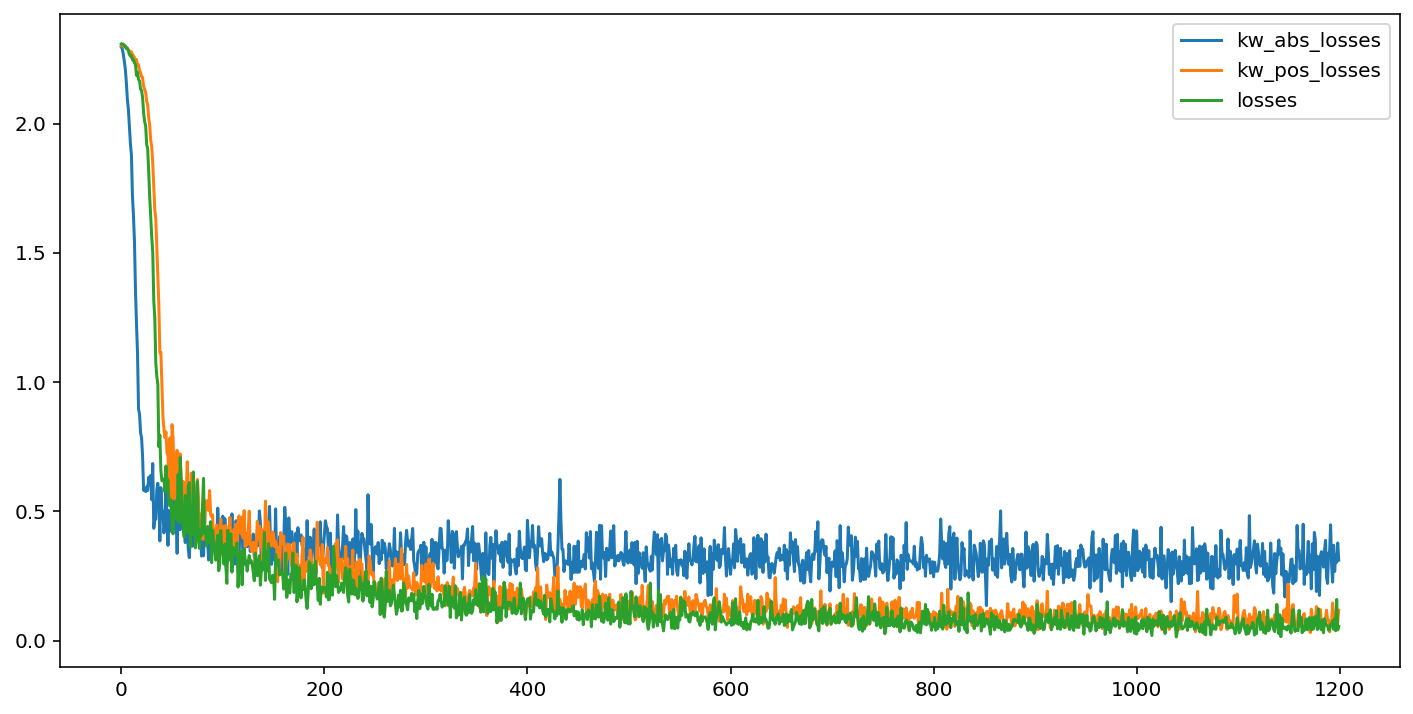

In [438]:
plt.plot(kw_losses, label='kw_abs_losses')
plt.plot(kwp_losses, label='kw_pos_losses')
plt.plot(losses, label='losses')
plt.legend();

#### Evaluate the role of boosting

In [453]:
# kWinners without boosting
from functions import KWinners
model_gen = lambda k: nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    KWinners(k_perc=k, use_boosting=False),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    KWinners(k_perc=k, use_boosting=False),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    KWinners(k_perc=k, use_boosting=False),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)

model = model_gen(k=0.1)
fit(model, dataset, epochs=1, epoch_eval=False);

Training Accuracy before training: 0.1263
Loss: 8.99374299
Loss: 8.70009977
Loss: 4.99155512
Training Accuracy after training: 0.8307
---------------------------
Test Accuracy after training: 0.8138


In [454]:
# kWinners with boosting
from functions import KWinners
model_gen = lambda k: nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    KWinners(k_perc=k, use_boosting=True),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    KWinners(k_perc=k, use_boosting=True),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    KWinners(k_perc=k, use_boosting=True),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)

model = model_gen(k=0.1)
fit(model, dataset, epochs=1, epoch_eval=False);

Training Accuracy before training: 0.1224
Loss: 9.01356246
Loss: 8.69631581
Loss: 5.94143802
Training Accuracy after training: 0.7982
---------------------------
Test Accuracy after training: 0.7930


In [465]:
# Exploring several values for beta
from functions import KWinners
model_gen = lambda k,b: nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    KWinners(k_perc=k, use_boosting=True, beta=b),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    KWinners(k_perc=k, use_boosting=True, beta=b),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    KWinners(k_perc=k, use_boosting=True, beta=b),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)

for b in [0, 0.01, 0.02, 0.05, 0.1]:
    model = model_gen(k=0.1, b=b)
    print("Beta: %f" % b)
    fit(model, dataset, epochs=1, epoch_eval=False);

Beta: 0.000000
Training Accuracy before training: 0.0898
Loss: 8.98815040
Loss: 8.77536274
Loss: 6.98788743
Training Accuracy after training: 0.7917
---------------------------
Test Accuracy after training: 0.7992
Beta: 0.010000
Training Accuracy before training: 0.1198
Loss: 8.99235159
Loss: 8.80934391
Loss: 7.56296981
Training Accuracy after training: 0.7617
---------------------------
Test Accuracy after training: 0.7676
Beta: 0.020000
Training Accuracy before training: 0.1406
Loss: 9.01190378
Loss: 8.72939453
Loss: 6.65350724
Training Accuracy after training: 0.7734
---------------------------
Test Accuracy after training: 0.7760
Beta: 0.050000
Training Accuracy before training: 0.1133
Loss: 8.99773650
Loss: 8.86656344
Loss: 8.14315118
Training Accuracy after training: 0.7604
---------------------------
Test Accuracy after training: 0.7503
Beta: 0.100000
Training Accuracy before training: 0.0781
Loss: 9.00390372
Loss: 8.86570197
Loss: 8.14782269
Training Accuracy after training: 0.

In [494]:
# Exploring several values for beta
from functions import KWinners
model_gen = lambda k,b: nn.Sequential(
    nn.Conv2d(1,32, kernel_size=3, stride=2, padding=1), # 14x14
    KWinners(k_perc=k, use_boosting=True, beta=b),
    nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1), # 7x7
    KWinners(k_perc=k, use_boosting=True, beta=b),
    nn.Conv2d(64,128, kernel_size=3, stride=2, padding=1), # 4x4 
    KWinners(k_perc=k, use_boosting=True, beta=b),
    Lambda(lambda x: x.view(x.size(0), -1)), # 128    
    nn.Linear(128*4*4,10) # 10
)

betas, losses, accs = [], [] ,[]
for b in [0, 0.002, 0.01]:
    model = model_gen(k=0.1, b=b)
    print("Beta: %f" % b)
    loss, acc = fit(model, dataset, epochs=50, epoch_eval=True, verbose=False);
    betas.append(b)
    losses.append(loss)
    accs.append(acc)

Beta: 0.000000
Training Accuracy before training: 0.0872
Training Accuracy after training: 0.9922
---------------------------
Test Accuracy after training: 0.9746
Beta: 0.002000
Training Accuracy before training: 0.0612
Training Accuracy after training: 0.9896
---------------------------
Test Accuracy after training: 0.9736
Beta: 0.010000
Training Accuracy before training: 0.1003
Training Accuracy after training: 0.9935
---------------------------
Test Accuracy after training: 0.9723


Plot loss and acc for different betas and answer the question if boosting helps or hurts

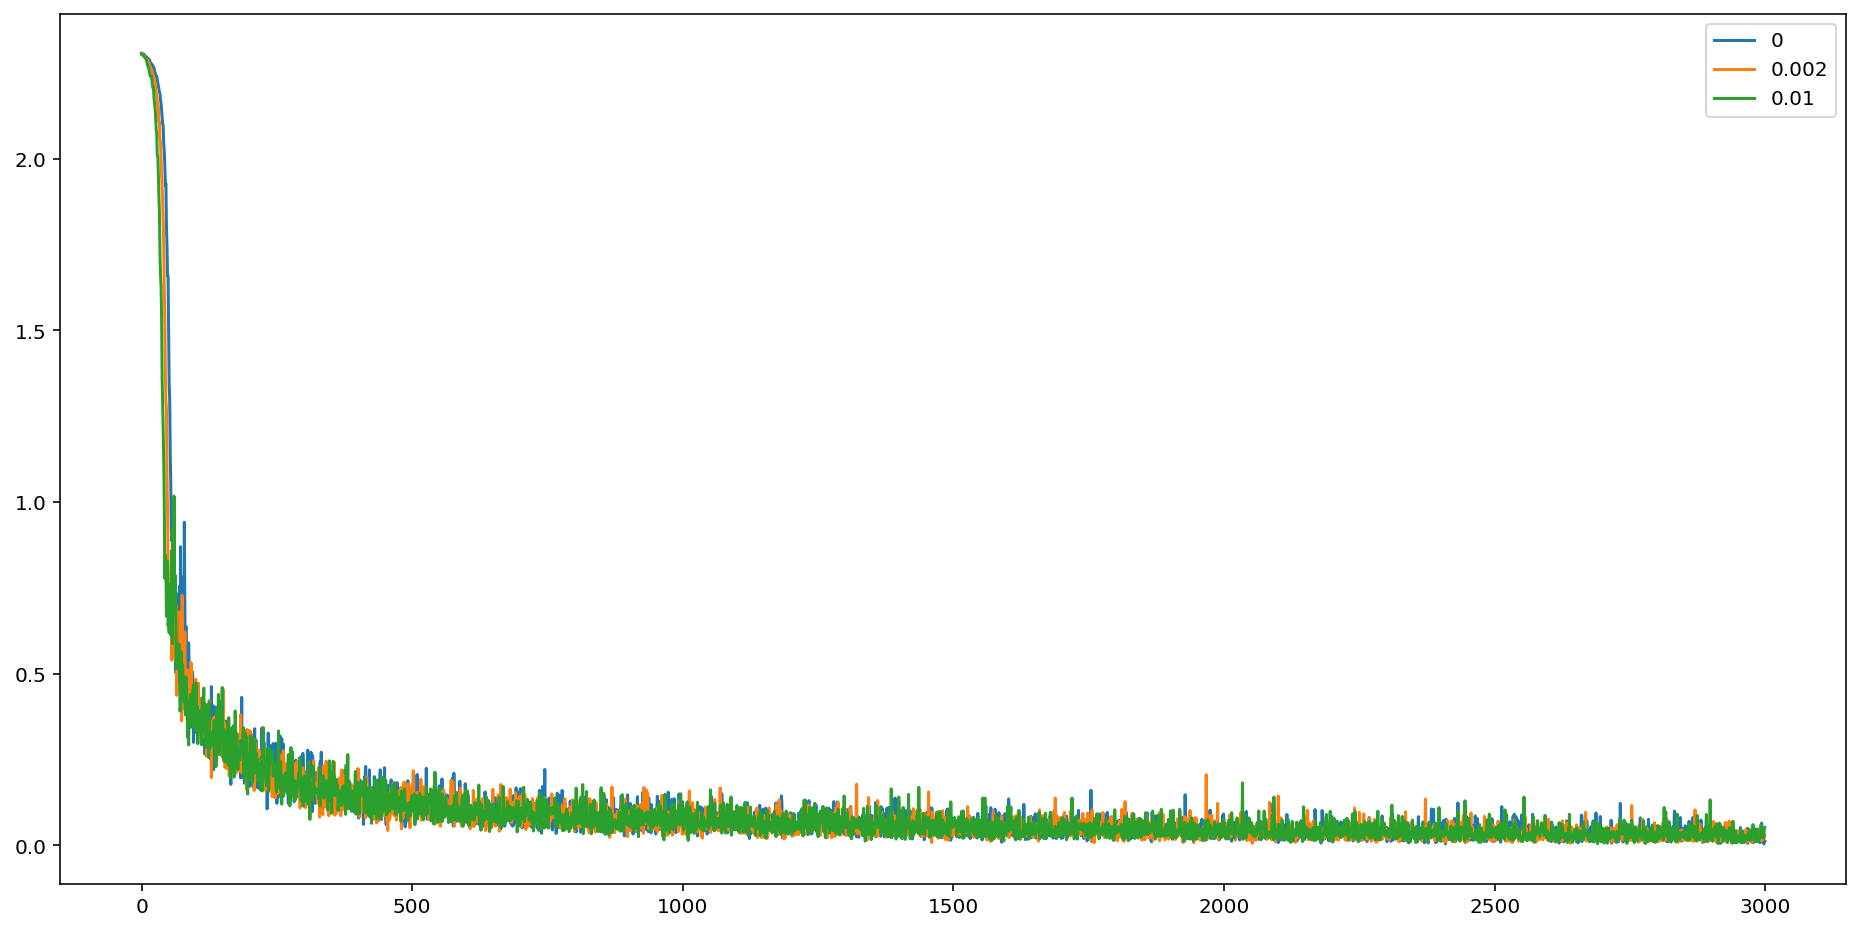

In [498]:
rcParams['figure.figsize'] = (16,8)
for beta, loss in zip(betas, losses):
    plt.plot(loss, label=str(beta))
plt.legend();

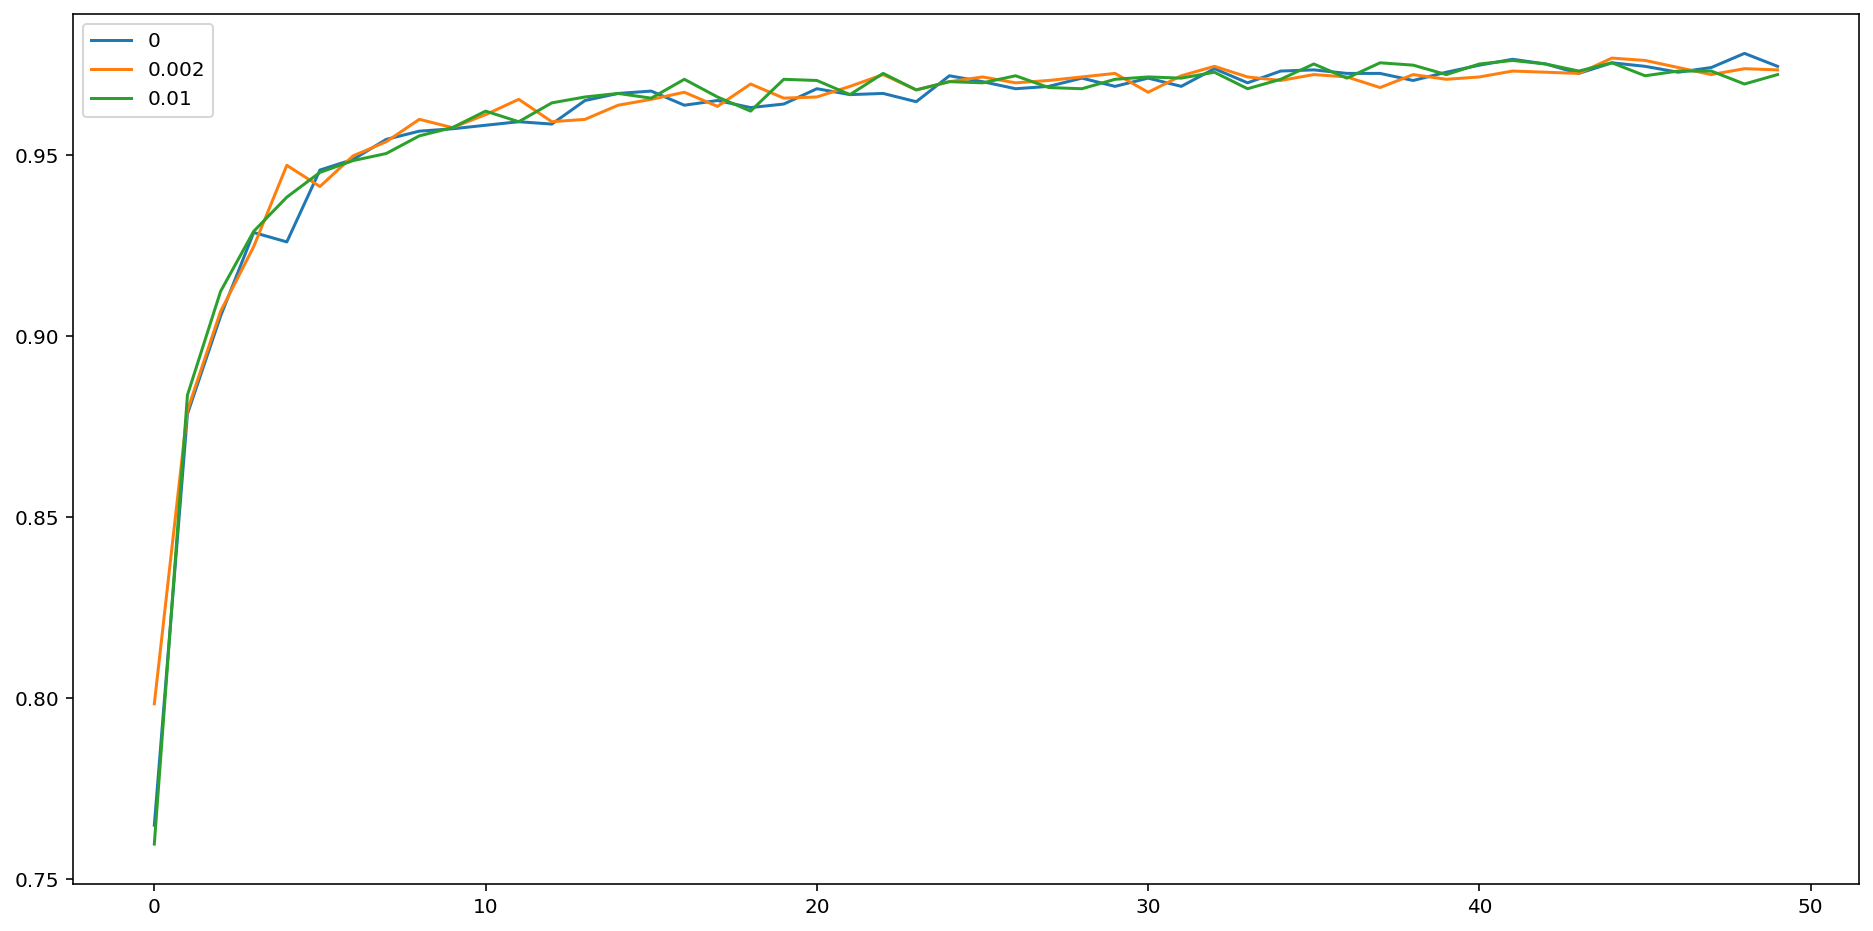

In [496]:
for beta, acc in zip(betas, accs):
    plt.plot(acc, label=str(beta))
plt.legend();

#### Exploration on how torch.expand is working in the background

In [ ]:
# topk experimentation
t = torch.randn((4,3,2))

In [467]:
t

tensor([[[-0.8587,  0.3650],
         [ 1.0872,  0.1732],
         [-0.1931, -1.3085]],

        [[-0.0944,  1.3081],
         [ 0.0840,  0.4794],
         [-0.1854, -1.8701]],

        [[-0.5506, -1.2746],
         [ 0.9189,  1.3216],
         [ 0.0577,  0.7018]],

        [[-0.9030, -1.7370],
         [-0.9755,  0.0730],
         [-0.4975,  1.5974]]])

In [468]:
b = torch.ones((3,2)) * 2

In [469]:
b

tensor([[2., 2.],
        [2., 2.],
        [2., 2.]])

In [471]:
t.shape, b.shape

(torch.Size([4, 3, 2]), torch.Size([3, 2]))

In [473]:
b.expand((4,3,2))

tensor([[[2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.]],

        [[2., 2.],
         [2., 2.],
         [2., 2.]]])

In [474]:
t * b.expand((4,3,2))

tensor([[[-1.7174,  0.7301],
         [ 2.1744,  0.3463],
         [-0.3862, -2.6169]],

        [[-0.1888,  2.6162],
         [ 0.1679,  0.9589],
         [-0.3709, -3.7401]],

        [[-1.1013, -2.5493],
         [ 1.8378,  2.6431],
         [ 0.1153,  1.4037]],

        [[-1.8060, -3.4740],
         [-1.9510,  0.1460],
         [-0.9951,  3.1948]]])

#### Exploration on how to select kth winners in torch

In [296]:
# topk experimentation
t = torch.randn((4,3,2))

In [310]:
t

tensor([[[-0.8587,  0.3650],
         [ 1.0872,  0.1732],
         [-0.1931, -1.3085]],

        [[-0.0944,  1.3081],
         [ 0.0840,  0.4794],
         [-0.1854, -1.8701]],

        [[-0.5506, -1.2746],
         [ 0.9189,  1.3216],
         [ 0.0577,  0.7018]],

        [[-0.9030, -1.7370],
         [-0.9755,  0.0730],
         [-0.4975,  1.5974]]])

In [320]:
tx = t.view(t.size()[0], -1)
print(tx.size())
val, _ = torch.kthvalue(tx, 1, dim=-1)
val

torch.Size([4, 6])


tensor([-1.3085, -1.8701, -1.2746, -1.7370])

In [337]:
[t.size()[0]] + [1 for _ in range(len(t.size())-1)]

[4, 1, 1]

In [341]:
t.shape

torch.Size([4, 3, 2])

In [342]:
(t > val.view(4,1,1)).sum(dim=0).shape

torch.Size([3, 2])

In [343]:
(t > val.view(4,1,1)).sum(dim=0)

tensor([[4, 2],
        [4, 4],
        [4, 2]])

In [340]:
t > val.view(4,1,1)

tensor([[[1, 1],
         [1, 1],
         [1, 0]],

        [[1, 1],
         [1, 1],
         [1, 0]],

        [[1, 0],
         [1, 1],
         [1, 1]],

        [[1, 0],
         [1, 1],
         [1, 1]]], dtype=torch.uint8)

In [328]:
t.shape

torch.Size([4, 3, 2])

In [330]:
val.view(4,1,1).shape

torch.Size([4, 1, 1])

In [331]:
val.view(4,1,1)

tensor([[[-1.3085]],

        [[-1.8701]],

        [[-1.2746]],

        [[-1.7370]]])

In [313]:
val, ind = torch.topk(t, k=1, dim=2)

In [314]:
ind

tensor([[[1],
         [0],
         [0]],

        [[1],
         [1],
         [0]],

        [[0],
         [1],
         [1]],

        [[0],
         [1],
         [1]]])

In [287]:
ind.shape

torch.Size([10, 2])

In [288]:
t.shape

torch.Size([10, 10])

In [289]:
t[ind].shape

torch.Size([10, 2, 10])

In [285]:
t.shape

torch.Size([10, 10])

In [290]:
# get indices
# apply indices
mask = torch.zeros_like(t)
mask.scatter(1, ind, 1.)

tensor([[0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])

In [286]:
ind

tensor([[7, 3],
        [3, 7],
        [4, 8],
        [4, 1],
        [5, 7],
        [5, 3],
        [4, 1],
        [6, 3],
        [8, 4],
        [6, 5]])

In [509]:
t = torch.randn(4,4,3)

In [510]:
t

tensor([[[ 0.7469,  0.8553, -1.4941],
         [-0.8793,  0.3501, -0.7851],
         [ 1.6777, -0.4477, -0.7974],
         [ 0.5982,  0.1408, -0.1138]],

        [[ 0.0258, -0.1167,  1.4570],
         [ 0.7951, -0.0026,  0.1722],
         [-1.0470, -2.0572,  0.5841],
         [-0.2269,  0.0349,  0.3652]],

        [[ 0.6581, -1.2306,  0.2728],
         [-1.6131, -0.1629,  1.4430],
         [-0.5600, -0.6853,  1.3488],
         [-0.1763, -0.4766, -0.0918]],

        [[-0.1463, -1.1577,  0.1479],
         [-1.0374, -2.0516, -0.3279],
         [-0.9665, -0.1928,  0.5775],
         [-0.0735, -1.0916,  0.6450]]])

In [512]:
t.topk(2, dim=2)

torch.return_types.topk(
values=tensor([[[ 0.8553,  0.7469],
         [ 0.3501, -0.7851],
         [ 1.6777, -0.4477],
         [ 0.5982,  0.1408]],

        [[ 1.4570,  0.0258],
         [ 0.7951,  0.1722],
         [ 0.5841, -1.0470],
         [ 0.3652,  0.0349]],

        [[ 0.6581,  0.2728],
         [ 1.4430, -0.1629],
         [ 1.3488, -0.5600],
         [-0.0918, -0.1763]],